In [1]:
import pytimedinput

In [4]:
%run gen_data.py

23-11-09 00:13:41|MOD:gen_data    |: Data loading start!


Preparing day_trading_data data...
arr shape : (5264, 6202, 1, 6) , row shape : (5264,) , col shape : (6202,)
Preparing day_ylabels_data data...
arr shape : (5249, 6191, 1, 2) , row shape : (5249,) , col shape : (6191,)
Preparing 15m_trading_data data...


23-11-09 00:20:02|MOD:gen_data    |: [day] Data avg and std generation start!


arr shape : (5204, 3302, 16, 6) , row shape : (5204,) , col shape : (3302,)
Loading day trading data finished, cost 5.64 Secs
torch.Size([5264, 920, 1, 6])


23-11-09 00:20:19|MOD:gen_data    |: [15m] Data avg and std generation start!


Loading 15m trading data finished, cost 45.60 Secs
torch.Size([5204, 340, 1, 6])


23-11-09 00:21:36|MOD:gen_data    |: Data loading Finished! Cost 475.09 Seconds


In [11]:
a = torch.rand(10000,1024)
n = torch.nn.Sequential(*[torch.nn.Linear(1024,1024) for _ in range(10)])
y = n(a)

In [13]:
a = torch.rand(10000,1024).to(torch.device('cuda:0'))
n = torch.nn.Sequential(*[torch.nn.Linear(1024,1024) for _ in range(10)]).to(torch.device('cuda:0'))
y = n(a)

In [5]:
%run run_model.py --process=0 --rawname=1 --resume=0 --anchoring=0

23-11-09 00:26:34|MOD:run_model   |: Process Queue : Data + Train + Test + Instance
23-11-09 00:26:34|MOD:run_model   |: Directories of [GeneralRNN_day] deletion Confirmed!
23-11-09 00:26:34|MOD:run_model   |: Start Process [Load Data]!
23-11-09 00:26:43|MOD:run_model   |: Finish Process [Load Data]! Cost 8.5Secs
23-11-09 00:26:43|MOD:run_model   |: Start Process [Train Model]!
23-11-09 00:26:43|MOD:run_model   |: Model Parameters:
Basic Parameters : 
MODEL_PARAM : 
TRAIN_PARAM : 
COMPT_PARAM : 
23-11-09 00:26:43|MOD:run_model   |: Start Training Models!


DEVICE [cuda:0] | DDTYPE [torch.float32] | BATCH_SIZE [2000].
NAME [GeneralRNN_day] | MODULE [GeneralRNN] | DATATYPE [day] | NUM_MODELS [2].
BEG_DATE [20170103] | END_DATE [20230804] | INTERVAL [120] | INPUT_STEP_DAY [5] | TEST_STEP_DAY [1].
{'hidden_dim': [16, 32],
 'seqlens': [{'day': 40, '15m': 20, 'dms': 40}],
 'rnn_layers': [4],
 'mlp_layers': [2],
 'dropout': 0.1,
 'fc_in': [True],
 'fc_att': [True],
 'type_rnn': ['tcn'],
 'rnn_att': [False],
 'ordered_param_group': [False],
 'num_output': [1],
 'hidden_as_factor': [False],
 'kernel_size': [3],
 'ATF_mask': {'causal': False, 'gaussian': False, 'tradegap': False}}
{'criterion': {'loss': 'ccc', 'metric': 'pearson', 'penalty': {'hidden_orthogonality': 0.001}},
 'trainer': {'optimizer': {'name': 'Adam', 'param': {}},
             'scheduler': {'name': 'cycle', 'param': {'base_lr': 1e-07, 'step_size_up': 4}},
             'learn_rate': {'base': 0.005,
                            'ratio': {'attempt': [1, 0.1, 10, 0.01, 100], 'round': [

GeneralRNN_day #0 @20170103 LoadData Cost   11.4Secs
FirstBite Ep#  0 : loss  0.99993, train 0.00031, valid-0.00021, max-0.0002, best-0.0002, lr1.0e-07


KeyboardInterrupt: 

In [49]:
import shutil , os
folder = './model'
save_model = ['.ipynb_checkpoints', 'LSTM_day','GRU_day','Transformer_day','GeneralRNN_day','GeneralRNN_day_Trans_vs_LSTM']
# [print(f'{folder}/{p}') for p in os.listdir(folder) if not p in save_model]

import shutil
shutil.rmtree('./model/DoubleGRU_both_single')

In [7]:
import torch
import torch.nn as nn

b , s , f , h = 2000 , 30 , 6 , 8
x = torch.rand(b,s,f)
x[int(b*0.9):] = torch.nan

class PositionalEncoding(nn.Module):
    def __init__(self, input_dim, dropout=0.0, max_len=1000,**kwargs):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.seq_len = max_len
        self.P = torch.zeros(1 , self.seq_len, input_dim)
        X = torch.arange(self.seq_len, dtype=torch.float).reshape(-1,1) / torch.pow(10000,torch.arange(0, input_dim, 2 ,dtype=torch.float) / input_dim)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X[:,:input_dim//2])
    def forward(self, inputs):
        return self.dropout(inputs + self.P[:,:inputs.shape[1],:].to(inputs.device))
    
class TimeWiseTranformer(nn.Module):
    def __init__(self , input_dim , hidden_dim , ffn_dim = None , num_heads = 8 , num_enclayer = 2 , dropout=0.0):
        super().__init__()
        assert hidden_dim % num_heads == 0
        ffn_dim = 4 * hidden_dim if ffn_dim is None else ffn_dim
        self.fc_in = nn.Linear(input_dim,hidden_dim)
        self.pos_enc = PositionalEncoding(hidden_dim,dropout=dropout)
        enc_layer = nn.TransformerEncoderLayer(hidden_dim , num_heads, dim_feedforward=ffn_dim , dropout=dropout , batch_first=True)
        self.trans = nn.TransformerEncoder(enc_layer , num_enclayer)
    def forward(self, inputs):
        hidden = self.fc_in(inputs)
        hidden = self.pos_enc(hidden)
        return self.trans(hidden)

tf = TimeWiseTranformer(f,h,num_enclayer=6)
# tf(x).select(-2,-1).shape
tf(x).shape

a = locals()['TimeWiseTranformer']
a

__main__.TimeWiseTranformer

In [2]:
import torch
import torch.nn as nn
from mymodel import *

b , s , f , h = 2000 , 30 , 6 , 8
x = torch.rand(b,s,f)
x[int(b*0.9):] = torch.nan

net = mod_transformer(f,h)
net(x).shape

torch.Size([2000, 30, 8])

In [92]:
import torch
import matplotlib.pyplot as plt
base_lr = 5e-2
max_lr  = 1e-1
min_lr = base_lr * 1e-4

net = torch.nn.Sequential(torch.nn.Linear(10,10) , torch.nn.Linear(10,1))
net_base_lr = [{'params': p , 'lr':l , 'lr_param' : l} for l,p in zip([base_lr , base_lr/2] , net.parameters())]
opt = torch.optim.Adam(net_base_lr , 0.001)


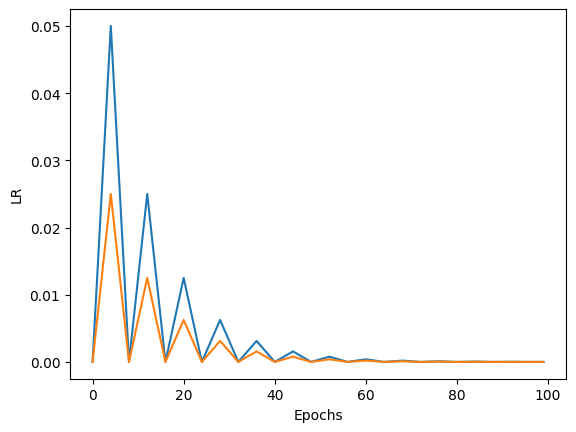

In [106]:
shd = torch.optim.lr_scheduler.CyclicLR(opt, base_lr = min_lr, max_lr = [pg['lr_param'] for pg in opt.param_groups], step_size_up=4,step_size_down=4,  mode='triangular2', cycle_momentum=False)
net.train()
x = torch.rand(100,10)
y = torch.rand(100,1)
lr_list1 = []
lr_list2 = []
for i in range(100):
    lr_list1.append(opt.param_groups[0]['lr'])
    lr_list2.append(opt.param_groups[1]['lr']) 
    loss = (y - net(x)).square().sum()
    opt.zero_grad()
    loss.backward()
    opt.step()
    shd.step()
    
plt.plot(range(100), lr_list1 , lr_list2)
plt.xlabel('Epochs')
plt.ylabel('LR')
plt.show()

In [101]:
opt.param_groups

[{'params': [Parameter containing:
   tensor([[-0.1464, -0.0394,  0.1021, -0.2248,  0.0035, -0.0685, -0.0087, -0.0724,
            -0.0245, -0.0974],
           [-0.0542,  0.1223,  0.2141,  0.1663,  0.1913, -0.0680, -0.0256,  0.0460,
            -0.2598,  0.1209],
           [-0.2284,  0.0395,  0.0189, -0.1898, -0.1294,  0.2278,  0.0854, -0.0516,
            -0.3525,  0.2948],
           [ 0.0383,  0.2897, -0.3093, -0.0379,  0.3246,  0.1595,  0.0146, -0.3545,
             0.4198, -0.0809],
           [ 0.2159,  0.1753, -0.1785, -0.2337,  0.1250, -0.0578, -0.2420, -0.1579,
             0.1073, -0.3070],
           [-0.1408,  0.0366,  0.1050,  0.3229,  0.2682, -0.0596,  0.0254, -0.1598,
            -0.1776, -0.0287],
           [-0.0647, -0.2756,  0.0234, -0.0710,  0.1470,  0.3596,  0.0437, -0.0010,
            -0.1295, -0.2085],
           [ 0.1424, -0.3624, -0.0210,  0.1511,  0.2143,  0.0898, -0.1272,  0.1678,
            -0.2389, -0.2046],
           [ 0.1213, -0.0286, -0.2437,  0.243

In [41]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm

class mod_tcn_block(nn.Module):
    def __init__(self, input_dim , output_dim , dilation, dropout=0.0 , kernel_size=2):
        super().__init__()
        padding = (kernel_size-1) * dilation
        self.conv1 = weight_norm(nn.Conv1d(input_dim , output_dim, kernel_size, padding=padding, dilation=dilation))
        self.conv2 = weight_norm(nn.Conv1d(output_dim, output_dim, kernel_size, padding=padding, dilation=dilation))
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        
        self.net = nn.Sequential(self.conv1, self._chomp(padding), nn.ReLU(), nn.Dropout(dropout), 
                                 self.conv2, self._chomp(padding), nn.ReLU(), nn.Dropout(dropout))
        
        if input_dim != output_dim:
            self.residual = nn.Conv1d(input_dim , output_dim, 1)
            self.residual.weight.data.normal_(0, 0.01)
        else:
            self.residual = nn.Sequential()
        self.relu = nn.ReLU()

    def forward(self, inputs):
        output = self.net(inputs)
        output = self.relu(output + self.residual(inputs))
        return output
    
    class _chomp(nn.Module):
        def __init__(self, padding):
            super().__init__()
            self.padding = padding
        def forward(self, x):
            return x[:, :, :-self.padding] # .contiguous()

class mod_tcn(nn.Module):
    def __init__(self, input_dim , output_dim , dropout=0.0 , num_layers = 2):
        super().__init__()
        num_layers = max(2 , num_layers)
        layers = []
        for i in range(num_layers):
            dilation = 2 ** i
            inp_d , out_dim = (input_dim , output_dim) if i == 0 else (output_dim , output_dim)
            layers += [mod_tcn_block(inp_d, out_dim, dilation=dilation, dropout=dropout)]
        self.net = nn.Sequential(*layers)

    def forward(self, inputs):
        output = self.net(inputs.permute(0,2,1)).permute(0,2,1)
        return output

b , s , f , o = 100 , 20 , 2 , 6
x = torch.rand(b,s,f)
tcn = mod_tcn(2 , 32)
tcn(x).shape

torch.Size([100, 20, 32])

In [26]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm

b , s , f , o = 100 , 20 , 2 , 6
x = torch.rand(b,s,f)
i = 0
dilation = 2 ** i
in_channels = f
out_channels = o
k = 2
padding = (k-1) * dilation
print(padding)

net = weight_norm(nn.Conv1d(in_channels, out_channels, kernel_size = k, stride=1, padding=padding, dilation=dilation))
net(x.permute(0,2,1)).shape

1


torch.Size([100, 6, 21])

In [27]:
net.state_dict()

OrderedDict([('bias',
              tensor([ 0.2536,  0.0380,  0.1633,  0.1347,  0.3025, -0.1907])),
             ('weight_g',
              tensor([[[0.5266]],
              
                      [[0.3966]],
              
                      [[0.6698]],
              
                      [[0.4292]],
              
                      [[0.7563]],
              
                      [[0.6856]]])),
             ('weight_v',
              tensor([[[-0.1100, -0.1176],
                       [-0.4663, -0.1842]],
              
                      [[ 0.1492, -0.2585],
                       [-0.0953, -0.2432]],
              
                      [[-0.2878, -0.4528],
                       [-0.3931, -0.0788]],
              
                      [[ 0.0944, -0.0259],
                       [-0.0928, -0.4074]],
              
                      [[ 0.3874, -0.4320],
                       [-0.4850, -0.0065]],
              
                      [[-0.2100,  0.3369],
            

In [52]:
torch.nn.utils.parametrizations.weight_norm

AttributeError: module 'torch.nn.utils.parametrizations' has no attribute 'weight_norm'

In [55]:
net(x.permute(0,2,1)).shape
a = torch.optim.swa_utils.AveragedModel(net)

RuntimeError: Only Tensors created explicitly by the user (graph leaves) support the deepcopy protocol at the moment

In [1]:
import torch , copy
print(torch.__version__)
net = torch.nn.Conv1d(10,10,3)
a = copy.deepcopy(net)

2.1.0+cu121


In [2]:
net = torch.nn.utils.parametrizations.weight_norm(torch.nn.Conv1d(10,10,3))
a = copy.deepcopy(net)